In [2]:
import pandas as pd
import numpy as np
from models.patchTST import PatchTST
from datasets import Dataset_Custom, Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Pred

### Determine size, number of channels for each dataset and each split

In [3]:
splits = ['train', 'val', 'test']
paths = ['./datasets/illness/', './datasets/electricity/', './datasets/traffic/', './datasets/weather',
            './datasets/ETT-small', './datasets/ETT-small', 
            './datasets/ETT-small', './datasets/ETT-small']
files = ['national_illness.csv', 'electricity.csv', 'traffic.csv','weather.csv', 'ETTh1.csv', 'ETTh2.csv', 
        'ETTm1.csv', 'ETTm2.csv']
freq = ['d', 'h', 'h', 't', 'h', 'h', 
        't', 't']
feat_len = [7, 321, 862, 21, 7, 7, 
            7, 7]

epochs = [100, 5, 5, 10, 20, 20, 
            20, 20]
batch_size=[1, 4, 4, 16, 16, 16, 
            128, 128]

In [4]:
df = pd.DataFrame(columns=['dataset', 'split', 'size', 'features'])

for split in splits:
    for i in range(len(files)):
        seq_len = 336
        target_len = 96

        if files[i] == 'national_illness.csv':
            seq_len = 96
            target_len = 24

        dataset = Dataset_Custom(root_path=paths[i], data_path=files[i], freq=freq[i], flag=split, 
                                 features='M', size = (seq_len, 0, target_len))
        
        # add dataset size, nummber of features, and what split its coming from into the df
        df = pd.concat([df, pd.DataFrame([[files[i], split, len(dataset), feat_len[i]]], columns=['dataset', 'split', 'size', 'features'])])

In [9]:
df

,dataset,split,size,features
0,national_illness.csv,train,557,7
0,electricity.csv,train,17981,321
0,traffic.csv,train,11849,862
0,weather.csv,train,36456,21
0,ETTh1.csv,train,11763,7
0,ETTh2.csv,train,11763,7
0,ETTm1.csv,train,48345,7
0,ETTm2.csv,train,48345,7
0,national_illness.csv,val,74,7
0,electricity.csv,val,2537,321


In [10]:
Dataset_Custom(root_path=paths[0], flag="train", size=(seq_len, 0, target_len), 
                                            features='M', data_path=files[0], freq=freq[0], timeenc=1)

In [ ]:
results_dataset = ['illness', 'electricity', 'traffic', 'weather', 'ETTh1', 'ETTh2', 'ETTm1', 'ETTm2']
# first list is list of mae second of mse
results = {
    'max' : [[.9247, .3765, .3616, .2053, .5421, .3, .3998, .2359], [1.959, .2816, .5097, .1571, .6022, .1883, .3508, .1232]],
    'sum' : [[.9052, .3067, .3509, .206, .5121, .3175, .4005, .2414], [1.913, .2039, .5205, .1559, .5113, .2067, .357, .1273]],
    'all_tokens' : [[.7995, .2355, .2903, .205, .4594, .2961, .3993, .2317], [1.703, .1372, .4037, .1556, .4384, .1832, .356, .1214]],
    'patch_ema' : [[.825, .2274, None, None, None, None, None, None], [1.869, .1324, None, None, None, None, None, None]],
    'patch_cnn' : [[.8364, .2279, .2738, .2035, .4512, .2807, .3779, .2248], [1.789, .132, .3848, .1544, .4177, .1707, .3254, .1127]],
    'mean' : [[.8647, .3001, .3395, .2022, .4968, .3065, .3838, .2359], [1.905, .1978, .497, .1542, .4916, .1892, .333, .1243]],
    'base_patch' : [[.8604, .2274, .2747, .2049, .4602, .3039, .3813, .2279], [1.869, .1324, .3902, .1529, .438, .1934, .3318, .115]], 
    'neighbor_residual' : [[], []],
}

### Model

In [1]:
from train_supervised import patchTST
import torch

In [4]:
# load all of the checkpoints
checkpoints = []


# load traffic datset
dataset = Dataset_Custom(root_path='./datasets/traffic/', data_path='traffic.csv', freq='h', flag='test', 
                         features='M', size = (336, 0, 96))
# get random index of test set
idx = np.random.randint(0, len(dataset))
# get the data at that index
data = dataset[idx]
x, y, _, _ = data

results_dict = {}

for i in range(len(checkpoints)):
    model = patchTST.load_from_checkpoint(f'./trained_models/{checkpoints[i]}_best.ckpt')
    model.eval()
    # get the prediction
    pred = model(torch.tensor(x).unsqueeze(0).float())
    pred = pred.detach().numpy().squeeze()

    results_dict[checkpoints[i]] = {}
    results_dict[checkpoints[i]]['x'] = x
    results_dict[checkpoints[i]]['y'] = y
    results_dict[checkpoints[i]]['pred'] = pred

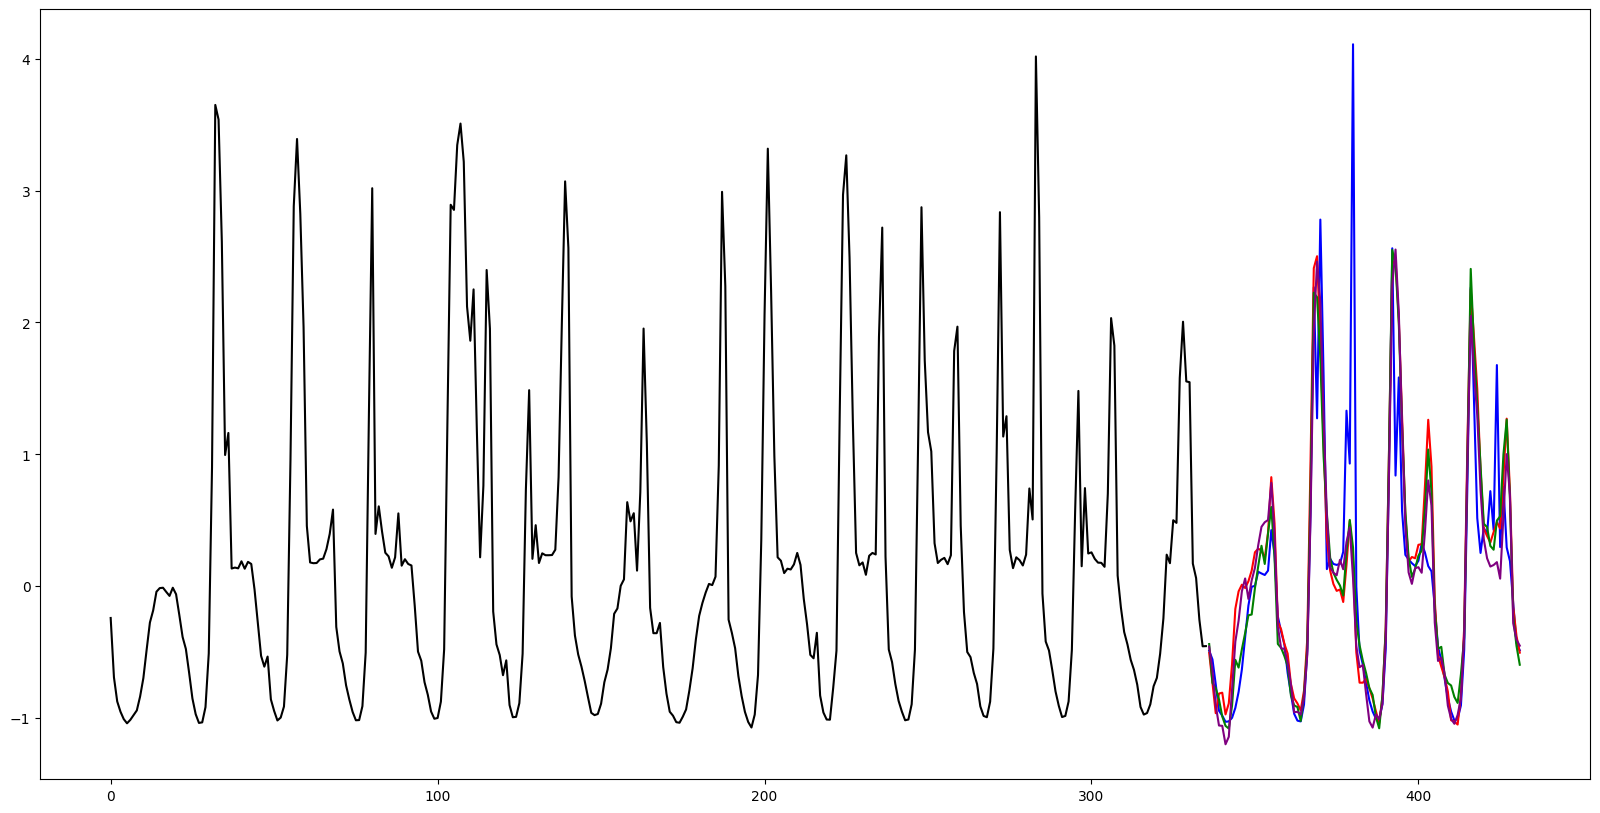

In [12]:
# take the first row and plot the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(results_dict[checkpoints[0]]['x'][:, 150], label='Input', color='black')

# plot ground truth y/predictions after the input
ax.plot(np.arange(336, 336+96), results_dict[checkpoints[i]]['y'][:, 150], label='Ground Truth', color='blue')
color_list = ['red', 'green', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan']

for i in range(len(checkpoints)):
    ax.plot(np.arange(336, 336+96), results_dict[checkpoints[i]]['pred'][:, 150], label='Prediction', color=color_list[i])


In [47]:
results_dict[checkpoints[0]]['x'][:, 0].shape

(336,)

In [12]:
model = patchTST.load_from_checkpoint(f'./trained_models/{checkpoints[0]}_best.ckpt')
model.eval()

patchTST(
  (model): PatchTST(
    (encoder): PatchTSTEncoder(
      (embed): Embedding(
        (embed): Sequential(
          (0): Linear(in_features=8, out_features=256, bias=True)
          (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
      )
      (encoder): Encoder(
        (layers): ModuleList(
          (0): ModuleList(
            (0): ModuleList(
              (0-1): 2 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
              (2): None
            )
            (1): Attention(
              (to_q): Linear(in_features=256, out_features=256, bias=False)
              (to_k): Linear(in_features=256, out_features=256, bias=False)
              (to_v): Linear(in_features=256, out_features=256, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=256, out_features=256, bias=False)
            )
            (2): Residual()
          )
          (1): ModuleList(
            (0): ModuleList(
 

In [19]:
pred = model(torch.tensor(x).unsqueeze(0).float())
pred.shape

torch.Size([1, 96, 862])